# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, Conv2D, MaxPooling2D, TimeDistributed
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

In [3]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load data

In [4]:
df = pd.read_csv('D://datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

# Get all the data out of datetime
# Could also get holiday data: https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

df['month'] = df.index.month
#df['week'] = df.index.week
#df['day'] = df.index.day
#df['year'] = df.index.year

df['month_end'] = df.index.is_month_end
df['month_start'] = df.index.is_month_start
df['quarter_end'] = df.index.is_quarter_end
df['quarter_start'] = df.index.is_quarter_start



In [5]:
df.head()

ePower  ePowerReturn          DD     DR         FF  \
datetime                                                                      
2017-02-22 12:00:00   87.033333           0.0  240.149994    0.0  11.266666   
2017-02-22 13:00:00   92.240356           0.0  236.633331  464.0  10.581667   
2017-02-22 14:00:00   93.821724           0.0  234.149994  196.0  10.683333   
2017-02-22 15:00:00  133.030640           0.0  237.500000  190.0  11.036667   
2017-02-22 16:00:00  111.652779           0.0  237.649994  562.0  10.688334   

                            FX         N            P          Q        RG  \
datetime                                                                     
2017-02-22 12:00:00  16.063334  6.000000  1006.333313  90.166664  0.000000   
2017-02-22 13:00:00  15.056667  6.833333  1006.016663  71.333336  0.200000   
2017-02-22 14:00:00  15.986667  7.833333  1005.483337  91.500000  0.033333   
2017-02-22 15:00:00  16.288334  7.666667  1004.983337  51.500000  0.050000   
2017-02-22 16:00:00  14.911667  7.666667  1004.650024  26.833334  0.616667   

                         ...             dwelling  gasPower_std  hour  \
datetime                 ...                                            
2017-02-22 12:00:00      ...        All dwellings           NaN    12   
2017-02-22 13:00:00      ...        All dwellings           NaN    13   
2017-02-22 14:00:00      ...        All dwellings           NaN    14   
2017-02-22 15:00:00      ...        All dwellings           NaN    15   
2017-02-22 16:00:00      ...        All dwellings           NaN    16   

                     dayofweek  season  month  month_end  month_start  \
datetime                                                                
2017-02-22 12:00:00          2       1      2      False        False   
2017-02-22 13:00:00          2       1      2      False        False   
2017-02-22 14:00:00          2       1      2      False        False   
2017-02-22 15:00:00          2       1      2      False        False   
2017-02-22 16:00:00          2       1      2      False        False   

                    quarter_end  quarter_start  
datetime                                        
2017-02-22 12:00:00       False          False  
2017-02-22 13:00:00       False          False  
2017-02-22 14:00:00       False          False  
2017-02-22 15:00:00       False          False  
2017-02-22 16:00:00       False          False  

[5 rows x 28 columns]

In [6]:
fig = create_corr_matrix(df, '', False)

c:\program files\python36\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Saving heatmap


<Figure size 432x288 with 0 Axes>

# Select data to use

Saving heatmap
Len of data:  6352


<Figure size 432x288 with 0 Axes>

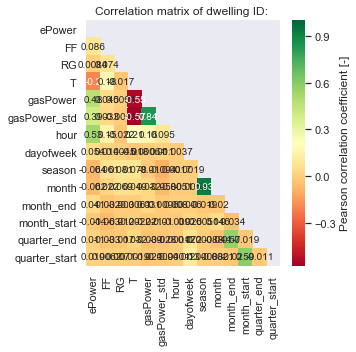

In [7]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

#data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower
data = data.drop(['ePowerReturn'], axis=1)


# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

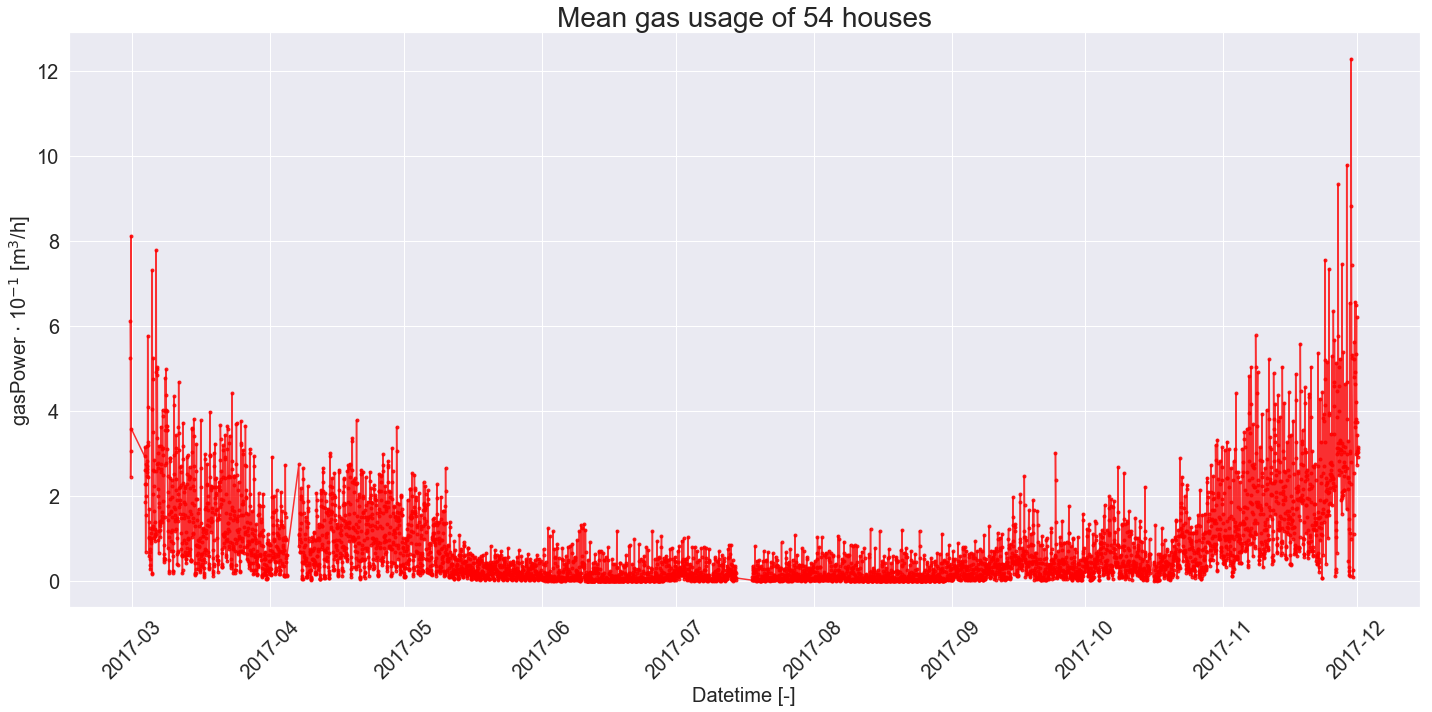

In [8]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Mean gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# Preprocessing

In [9]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']

data.head()

ePower        FF   RG         T  gasPower  \
datetime                                                             
2017-02-28 12:00:00  308.321701  9.067500  0.0  5.183333  6.115723   
2017-02-28 13:00:00  263.656273  8.684999  0.0  5.300000  5.238647   
2017-02-28 14:00:00  181.913345  8.296667  0.0  5.283333  2.451172   
2017-02-28 15:00:00  378.613129  6.918334  0.0  5.516667  3.065186   
2017-02-28 16:00:00  332.392082  6.583333  0.0  5.433333  8.120117   

                     gasPower_std  hour  dayofweek  season  month  month_end  \
datetime                                                                       
2017-02-28 12:00:00      0.085626    12          1       1      2       True   
2017-02-28 13:00:00      0.318250    13          1       1      2       True   
2017-02-28 14:00:00      0.041087    14          1       1      2       True   
2017-02-28 15:00:00      0.214238    15          1       1      2       True   
2017-02-28 16:00:00      0.014156    16          1       1      2       True   

                     month_start  quarter_end  quarter_start  gasPower_copy  
datetime                                                                     
2017-02-28 12:00:00        False        False          False       6.115723  
2017-02-28 13:00:00        False        False          False       5.238647  
2017-02-28 14:00:00        False        False          False       2.451172  
2017-02-28 15:00:00        False        False          False       3.065186  
2017-02-28 16:00:00        False        False          False       8.120117

In [10]:
#data = create_timeseries_history(data, columns_to_lookback=data.columns, n_lookback=5, dropnan=True)

In [11]:
#data = reduce_memory(data)

# datetime info to categorical

In [12]:
"""
Ideally would want to one-hot-encode season/month also?
But this does not make sense if like 4 (one hot encoded) months are none existant in the training set?
In the end maybe one hot encode all the datetime info + one hot encode houses based on their groups (energy label, area etc.).
"""

#columns_to_cat = ['year', 'month', 'day', 'hour', 'dayofweek', 'season']
columns_to_cat = ['hour', 'dayofweek', 'season', 'month', 'month_end', 'month_start', 'quarter_end', 'quarter_start']
data[columns_to_cat] = data[columns_to_cat].astype('category') # change datetypes to category

data = pd.get_dummies(data, columns=columns_to_cat) # One hot encoding the categories
data.head()

ePower        FF   RG         T  gasPower  \
datetime                                                             
2017-02-28 12:00:00  308.321701  9.067500  0.0  5.183333  6.115723   
2017-02-28 13:00:00  263.656273  8.684999  0.0  5.300000  5.238647   
2017-02-28 14:00:00  181.913345  8.296667  0.0  5.283333  2.451172   
2017-02-28 15:00:00  378.613129  6.918334  0.0  5.516667  3.065186   
2017-02-28 16:00:00  332.392082  6.583333  0.0  5.433333  8.120117   

                     gasPower_std  gasPower_copy  hour_0  hour_1  hour_2  \
datetime                                                                   
2017-02-28 12:00:00      0.085626       6.115723       0       0       0   
2017-02-28 13:00:00      0.318250       5.238647       0       0       0   
2017-02-28 14:00:00      0.041087       2.451172       0       0       0   
2017-02-28 15:00:00      0.214238       3.065186       0       0       0   
2017-02-28 16:00:00      0.014156       8.120117       0       0       0   

                            ...          month_11  month_12  month_end_False  \
datetime                    ...                                                
2017-02-28 12:00:00         ...                 0         0                0   
2017-02-28 13:00:00         ...                 0         0                0   
2017-02-28 14:00:00         ...                 0         0                0   
2017-02-28 15:00:00         ...                 0         0                0   
2017-02-28 16:00:00         ...                 0         0                0   

                     month_end_True  month_start_False  month_start_True  \
datetime                                                                   
2017-02-28 12:00:00               1                  1                 0   
2017-02-28 13:00:00               1                  1                 0   
2017-02-28 14:00:00               1                  1                 0   
2017-02-28 15:00:00               1                  1                 0   
2017-02-28 16:00:00               1                  1                 0   

                     quarter_end_False  quarter_end_True  quarter_start_False  \
datetime                                                                        
2017-02-28 12:00:00                  1                 0                    1   
2017-02-28 13:00:00                  1                 0                    1   
2017-02-28 14:00:00                  1                 0                    1   
2017-02-28 15:00:00                  1                 0                    1   
2017-02-28 16:00:00                  1                 0                    1   

                     quarter_start_True  
datetime                                 
2017-02-28 12:00:00                   0  
2017-02-28 13:00:00                   0  
2017-02-28 14:00:00                   0  
2017-02-28 15:00:00                   0  
2017-02-28 16:00:00                   0  

[5 rows x 61 columns]

# Preprocessing, data to lstm format

In [41]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.7 # This acctually is the train size, oops.
target_column = 'gasPower'

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column=target_column, scale_X=True)
X_train.shape

(4326, 120, 60)

In [42]:
X_train = X_train[:4325]
X_test= X_test[:1785]

y_train = y_train[:4325]
y_test= y_test[:1785]

"""
Check if this is the correct goal!!!!!!
"""
#y_train = y_train[::5] # take only each 5th item from the array
#y_test = y_test[::5]

len(y_train), len(y_test)

(4325, 1785)

In [43]:
# N_sample to lookback
lookback_n_samples= 5

# Some calculations for the reshaping
sequences_length_train = int((X_train.shape[0] / lookback_n_samples))
sequences_length_test = int((X_test.shape[0] / lookback_n_samples))

sequences_length_train, sequences_length_test

(865, 357)

In [44]:
#X_train = X_train.reshape(sequences_length_train, lookback_n_samples, X_train.shape[1], X_train.shape[2], 1)
#X_test = X_test.reshape(sequences_length_test, lookback_n_samples, X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

X_train.shape, X_test.shape

((4325, 120, 60), (1785, 120, 60))

In [45]:
X_train = np.stack((X_train,)*3, axis=-1) 
X_test = np.stack((X_test,)*3, axis=-1) 

In [46]:
X_train.shape, X_test.shape

((4325, 120, 60, 3), (1785, 120, 60, 3))

In [47]:
def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [48]:
from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers.normalization import BatchNormalization

from keras.layers import Input
from keras.models import Model

dropout = 0.2

# Pretrained CNN

In [49]:
from keras.models import Model
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.layers import Reshape, CuDNNGRU

# DenseNet121 has 121 layers

image_size = (120, 60)

batch_size = 8
freeze_layers = 100
num_epochs = 20
weights_final = 'model-DenseNet121-final.h5'

net = DenseNet121(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(image_size[0], image_size[1], 3))



In [63]:
net_output = net.output

# Add the following in chronologial order after net.output
output_shape = net.output_shape
print(output_shape)

net_output = Reshape((output_shape[1], output_shape[2]*output_shape[3]))(net_output)

for layer in net.layers[:freeze_layers]:
    layer.trainable = False
for layer in net.layers[freeze_layers:]:
    layer.trainable = True

(None, 3, 1, 1024)


# RNN Model

In [64]:
rnn = Sequential()
rnn.add(CuDNNGRU(16, return_sequences=True, kernel_initializer='TruncatedNormal'))
rnn.add(LeakyReLU())
rnn.add(Dropout(dropout))

rnn.add(CuDNNGRU(16, return_sequences=True, kernel_initializer='TruncatedNormal'))
rnn.add(LeakyReLU())
rnn.add(Dropout(dropout))

rnn.add(CuDNNGRU(16, return_sequences=False, kernel_initializer='TruncatedNormal'))
rnn.add(LeakyReLU())
rnn.add(Dropout(dropout))

# Dense Model

In [65]:
dense = Sequential()
dense.add(Dense(128, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(64, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

# output
dense.add(Dense(1))

# Put it all together

In [66]:
main_input = Input(shape=(1, 120, 60, 3)) # Data has been reshaped to (800, 5, 120, 60, 1)

model = TimeDistributed(net_output)(main_input) # this should make the cnn 'run' 5 times?
model = rnn(model) # combine timedistributed cnn with rnn
model = dense(model) # add dense

AttributeError: 'Tensor' object has no attribute 'built'

# Final model

In [37]:
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 120, 60, 1)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 115200)         39744     
_________________________________________________________________
sequential_8 (Sequential)    (None, 16)                5533728   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 10497     
Total params: 5,583,969
Trainable params: 5,583,841
Non-trainable params: 128
_________________________________________________________________


# Learning rate finder

multi_model.fit(X_train, y_train, callbacks=[lr_finder] )

## Plot LR informartion

In [38]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 500 #135
bs = 2**8
print('Batch size: ', bs)

# Choose the highest learning rate where the loss is still improving by a lot
lr=1e-4

# 0.05 0.9 0 True
#sgd = SGD(lr=lr, momentum=0.9, decay=0, nesterov=True) # 0.005
sgd = SGD(lr=lr)
adam = Adam(lr=lr)

epoch_size = 3

# For more info see: https://www.jeremyjordan.me/nn-learning-rate/
# Not applying it correctly? 19-11-2018 20.24
schedule = SGDRScheduler(min_lr=1e-4, # Pick the range where LR is ideal
                         max_lr=5e-2,
                         steps_per_epoch=np.ceil(epoch_size/bs),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

Batch size:  256


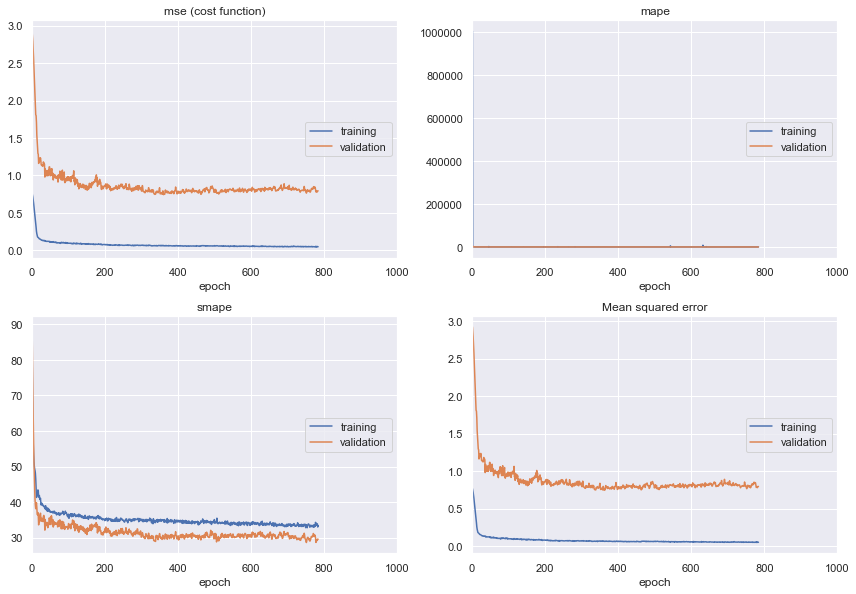

mse (cost function):
training   (min:    0.046, max:    0.766, cur:    0.050)
validation (min:    0.744, max:    2.924, cur:    0.795)

mape:
training   (min:   70.937, max: 1004100.948, cur:  215.984)
validation (min:   77.792, max: 5884.508, cur:   81.442)

smape:
training   (min:   32.793, max:   86.756, cur:   33.418)
validation (min:   28.650, max:   89.269, cur:   29.583)

Mean squared error:
training   (min:    0.046, max:    0.766, cur:    0.050)
validation (min:    0.744, max:    2.924, cur:    0.795)
Epoch 785/1000
3840/4325 [=========================>....] - ETA: 0s - loss: 0.0456 - mape: 84.5549 - smape: 32.7924 - mean_squared_error: 0.0456

KeyboardInterrupt: 

In [39]:
# compile & fit
final_model.compile(optimizer=adam, loss = ['mse'], metrics=[mape, smape, 'mse'])

early_stopping_monitor = EarlyStopping(patience=5000)


final_model.fit(X_train, y_train, epochs=1000, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[early_stopping_monitor, PlotLossesKeras()])

# Create plot

In [42]:
y_preds = final_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it


In [43]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result, _ = final_model.evaluate(X_test, y_test)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly.png', dpi=300)
print('FINISHED')

1785/1785 [==============================] - 2s 995us/step
FINISHED


# Make the same plot, but downsample the results to a day

In [46]:
# Get results, put it in a dataframe

y_preds = final_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

#result.to_csv('model _results _data/CNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1785,)


In [47]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

In [48]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)

Text(0.5, 1.0, 'Conv2D result \n MSE = 93.09 \n MAPE = 38.3 [%] \n SMAPE = 14.9 [%]')

# Save the model

In [1]:
model.save('model.h5')
model.save_weights('model_weights.h5')
print('FINISHED')

NameError: name 'model' is not defined

# Load the model

In [15]:
from keras.models import load_model
model = load_model('model.h5') # Load the architecture
moel = model.load_weights('model_weights.h5') # Set the weights

model.compile(optimizer='adam', loss = ['mse'], metrics=[mape, smape]) # Compile it (could also set to multi_gpu before this)
print('FINISHED')

FINISHED


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
model.summary()